In [1]:
# !pip install tensorflow_datasets
!pip install pydot  
!pip install graphviz

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [1]:
import glob

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121, InceptionResNetV2, Xception, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from trainTestSplit import LABELS, train_test_split
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [36]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20,20))
    if len(images_arr) > 1:
      axes = axes.flatten()
    else: axes = [axes]
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [37]:
batch_size = 16
IMG_HEIGHT = 300
IMG_WIDTH = 300
train_path, test_path = train_test_split(0.10, with_noise=False, random_seed=1)
total_train = sum([len(glob.glob(f'{train_path}/data/{label}/{label}*')) for label in LABELS])

For label **rock** there are 196 train images and 21 test images.
For label **paper** there are 343 train images and 38 test images.
For label **scissor** there are 233 train images and 25 test images.


In [38]:
image_gen_train = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=35,
        width_shift_range=.12,
        height_shift_range=.12,
        horizontal_flip=True,
        zoom_range=0.05,
        channel_shift_range=100,
        brightness_range=[0.45, 1.0],
        shear_range=20,
        validation_split=0.15
    )

In [39]:
labels = LABELS[:-1]

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                         directory='train',
                                                         shuffle=True,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         classes=labels,
                                                         class_mode='categorical',
                                                         subset='training')

validation_generator = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                         directory='train',
                                                         shuffle=True,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         classes=labels,
                                                         class_mode='categorical',
                                                         subset='validation')

Found 658 images belonging to 3 classes.
Found 114 images belonging to 3 classes.


In [40]:
checkpoint = ModelCheckpoint(
    'model.h5',
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    # save_weights_only=True,
    mode='auto'
)
es = EarlyStopping(patience=15)

In [41]:
# Add LR reduction with time due to loss
lr_red = ReduceLROnPlateau(monitor='acc', factor=0.5, verbose=1, mode='auto', cooldown=2, min_lr=1e-07, patience=5, min_delta=1e-03)

In [42]:
labels = LABELS[:-1]

def genericModel(base):
    model = Sequential()
    model.add(base)
    model.add(MaxPool2D())
    model.add(Flatten())
#     model.add(Dense(250, activation='relu'))
#     model.add(Dropout(0.3))
#     model.add(Dense(250, activation='relu'))
    model.add(Dense(len(labels), activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['acc'])
    return model

In [43]:
densenet = InceptionResNetV2(include_top=False, weights='imagenet', classes=3, input_shape=(300, 300, 3))

densenet.trainable = False
dnet = genericModel(densenet)
print(dnet.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 1536)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 24576)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 73731     
Total params: 54,410,467
Trainable params: 73,731
Non-trainable params: 54,336,736
_________________________________________________________________
None


In [44]:
# dnet.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['acc'])

In [45]:
history= dnet.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs=120,
    callbacks=[checkpoint, es, lr_red]
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 41 steps, validate for 7 steps
Epoch 1/120
40/41 [============================>.] - ETA: 0s - loss: 2.9776 - acc: 0.5160
Epoch 00001: val_acc improved from -inf to 0.80357, saving model to model.h5
41/41 [==============================] - 38s 937ms/step - loss: 2.9518 - acc: 0.5187 - val_loss: 1.0146 - val_acc: 0.8036
Epoch 2/120
40/41 [============================>.] - ETA: 0s - loss: 1.0547 - acc: 0.7572
Epoch 00002: val_acc did not improve from 0.80357
41/41 [==============================] - 20s 498ms/step - loss: 1.0334 - acc: 0.7617 - val_loss: 1.8028 - val_acc: 0.7143
Epoch 3/120
40/41 [============================>.] - ETA: 0s - loss: 0.9096 - acc: 0.7843
Epoch 00003: val_acc improved from 0.80357 to 0.82143, saving model to model.h5
41/41 [==============================] - 23s 557ms/step - loss: 0.8945 - acc: 0.7850 - val_loss: 0.6992 - val_acc: 0.8214
Epoch 4/120
40/41 [============================>.] - ETA: 0s - loss: 1.0190 - acc: 0.7700
Epoch 00004: val_acc did n

# Load Rock Paper Scissor from TF

In [2]:
import tensorflow_datasets as tfds

DATASET_NAME = 'rock_paper_scissors'

(dataset_tf_train_raw, dataset_tf_val_raw), dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
#     split='train'
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

In [3]:
dataset_info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)

In [4]:
# Function to convert label ID to labels string.
get_label_name = dataset_info.features['label'].int2str

def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        label = get_label_name(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

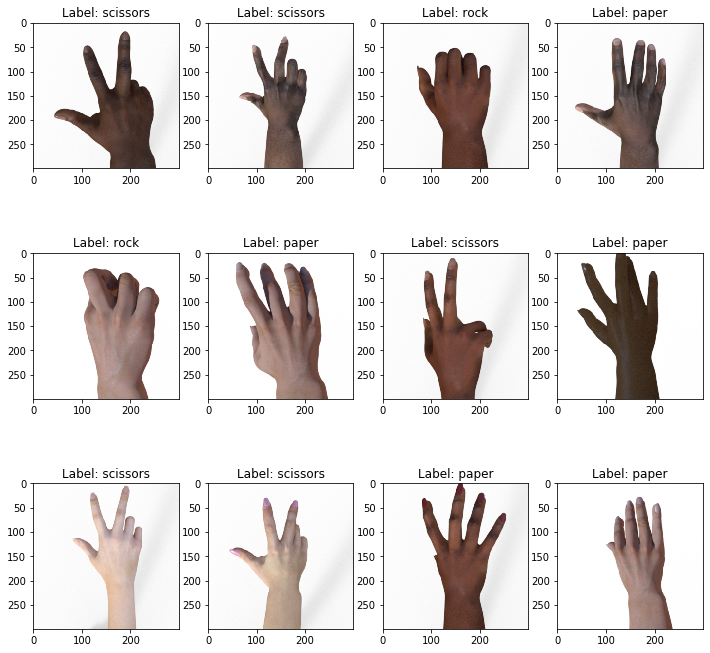

In [5]:
preview_dataset(dataset_tf_train_raw)

## Data preparation

In [6]:
def format_example(image, label):
    # Make image color values to be float.
    image = tf.cast(image, tf.float32)
    # Make image color values to be in [0..1] range.
    image = image / 255.
    # Make sure that image has a right size
    image = tf.image.resize(image, [300, 300])
    return image, label

In [7]:
dataset_tf_train = dataset_tf_train_raw.map(format_example)
dataset_tf_val = dataset_tf_val_raw.map(format_example)

In [8]:
# check the scaling
list(dataset_tf_train.take(1))

[(<tf.Tensor: shape=(300, 300, 3), dtype=float32, numpy=
  array([[[0.99607843, 0.99607843, 0.99607843],
          [0.99215686, 0.99215686, 0.99215686],
          [0.99607843, 0.99607843, 0.99607843],
          ...,
          [0.9843137 , 0.9843137 , 0.9843137 ],
          [0.98039216, 0.98039216, 0.98039216],
          [0.98039216, 0.98039216, 0.98039216]],
  
         [[0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99215686, 0.99215686, 0.99215686],
          ...,
          [0.98039216, 0.98039216, 0.98039216],
          [0.9843137 , 0.9843137 , 0.9843137 ],
          [0.9764706 , 0.9764706 , 0.9764706 ]],
  
         [[0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          ...,
          [0.9843137 , 0.9843137 , 0.9843137 ],
          [0.98039216, 0.98039216, 0.98039216],
          [0.9882353 , 0.9882353 , 0.9882353 ]],
  
         ...,
  
     

## Augmentation

In [9]:
import numpy as np

def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image

def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )

def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.5:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

def augment_zoom(image: tf.Tensor, min_zoom=0.8, max_zoom=1.0) -> tf.Tensor:
    image_width, image_height, image_colors = image.shape
    crop_size = (image_width, image_height)

    # Generate crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(min_zoom, max_zoom, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize(
            [img],
            boxes=boxes,
            box_indices=np.zeros(len(scales)),
            crop_size=crop_size
        )
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: image, lambda: random_crop(image))

def augment_data(image, label):
    image = augment_flip(image)
    image = augment_color(image)
    image = augment_rotation(image)
    image = augment_zoom(image)
    image = augment_inversion(image)
    return image, label

In [10]:
dataset_tf_train_augmented = dataset_tf_train.map(augment_data)

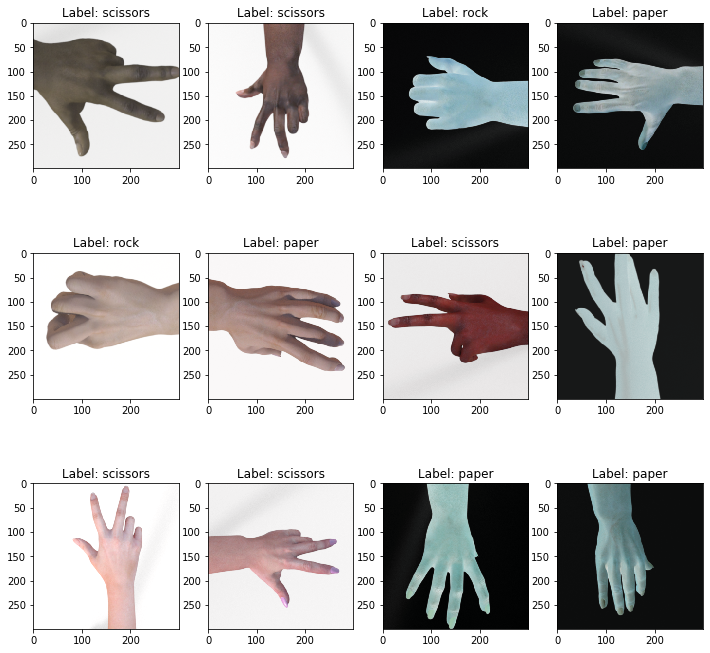

In [11]:
preview_dataset(dataset_tf_train_augmented)

## Shuffling and batching

In [12]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_VAL_EXAMPLES = dataset_info.splits['test'].num_examples

In [22]:
BATCH_SIZE = 200

dataset_tf_train_augmented_shuffled = dataset_tf_train_augmented.shuffle(
    buffer_size=NUM_TRAIN_EXAMPLES
)

dataset_tf_train_augmented_shuffled = dataset_tf_train_augmented_shuffled.batch(
    batch_size=BATCH_SIZE
)

In [23]:
# Prefetch will enable the input pipeline to asynchronously fetch batches while your model is training.
dataset_tf_train_augmented_shuffled = dataset_tf_train_augmented_shuffled.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

dataset_tf_val_shuffled = dataset_tf_val.batch(BATCH_SIZE)

In [24]:
print(dataset_tf_train_augmented_shuffled)
print(dataset_tf_val_shuffled)

<PrefetchDataset shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int64)>


In [25]:
# Debugging the batches using conversion to Numpy arrays.
batches = tfds.as_numpy(dataset_tf_train_augmented_shuffled)
for batch in batches:
    image_batch, label_batch = batch
    print('Label batch shape:', label_batch.shape, '\n')
    print('Image batch shape:', image_batch.shape, '\n')
    print('Label batch:', label_batch, '\n')
    
    for batch_item_index in range(len(image_batch)):
        print('First batch image:', image_batch[batch_item_index], '\n')
        plt.imshow(image_batch[batch_item_index])
        plt.show()
        # Break to shorten the output.
        break
    # Break to shorten the output.
    break

KeyboardInterrupt: 

## Continue training 

In [26]:
labels = LABELS[:-1]

def genericModel(base):
    model = Sequential()
    model.add(base)
    model.add(MaxPool2D())
    model.add(Flatten())
#     model.add(Dense(250, activation='relu'))
#     model.add(Dropout(0.3))
#     model.add(Dense(250, activation='relu'))
    model.add(Dense(len(labels), activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['acc'])
    return model

In [27]:
densenet = DenseNet121(include_top=False, weights='imagenet', classes=3, input_shape=(300, 300, 3))
densenet.trainable = False
dnet = genericModel(densenet)
print(dnet.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 9, 9, 1024)        7037504   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 1024)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 49155     
Total params: 7,086,659
Trainable params: 49,155
Non-trainable params: 7,037,504
_________________________________________________________________
None


In [28]:
history= dnet.fit(
    x = dataset_tf_train_augmented_shuffled.repeat(),
    validation_data = dataset_tf_val_shuffled.repeat(),
    steps_per_epoch= NUM_TRAIN_EXAMPLES // BATCH_SIZE,
    validation_steps = NUM_VAL_EXAMPLES // BATCH_SIZE if NUM_VAL_EXAMPLES // BATCH_SIZE else 1,
    epochs=5,
#     callbacks=[checkpoint, es, lr_red]
)

Train for 12 steps, validate for 1 steps
Epoch 1/5
 6/12 [==============>...............] - ETA: 58s - loss: 6.8598 - acc: 0.2140 

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  Failed to allocate memory for the batch of component 0
	 [[node IteratorGetNext (defined at <ipython-input-28-fc21e0296d9a>:6) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  Failed to allocate memory for the batch of component 0
	 [[node IteratorGetNext (defined at <ipython-input-28-fc21e0296d9a>:6) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[IteratorGetNext/_2]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_62981]

Function call stack:
distributed_function -> distributed_function


# Load the model

In [ ]:
from tensorflow.keras.models import load_model
trained_model = load_model('models/model.h5')

In [26]:
image_gen_test = ImageDataGenerator(
        rescale=1. / 255
    )
test_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                         directory='test',
                                                         shuffle=True,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         classes=labels,
                                                         class_mode='categorical')

Found 48 images belonging to 3 classes.


In [27]:
trained_model.evaluate(test_data_gen,
                      steps=test_data_gen.samples // batch_size)

  ...
    to  
  ['...']
3/3 [==============================] - 4s 1s/step - loss: 1.2553 - acc: 0.8125


[1.2553214232126872, 0.8125]

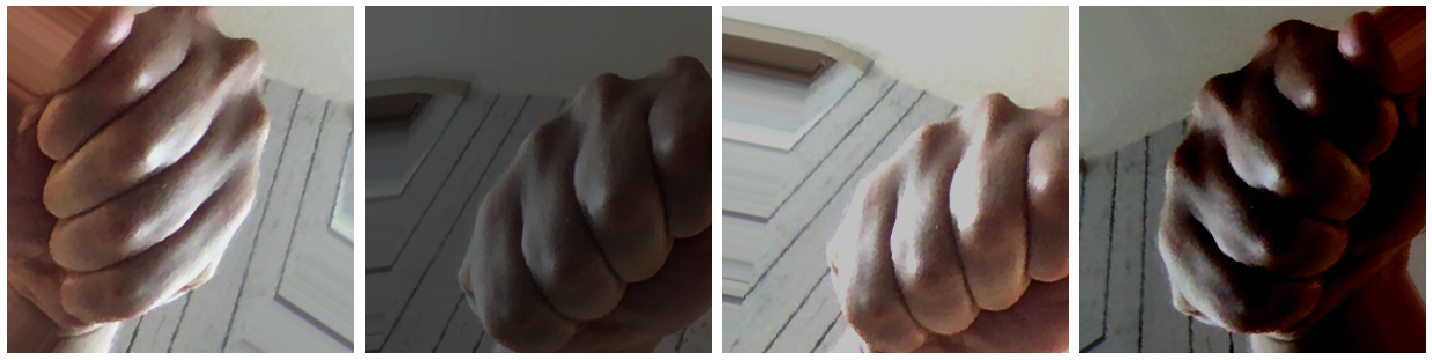

In [28]:
augmented_images = [test_data_gen[0][0][0] for i in range(4)]
plotImages(augmented_images)

In [32]:
trained_model.predict(augmented_images[1].reshape(1,300,300,3))

array([[1.0000000e+00, 1.9982503e-08, 1.5197456e-11]], dtype=float32)

In [35]:
plotImages(test_data_gen[1][0][0])

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


KeyboardInterrupt: 